## Chessboard Detection from Screenshot

In this notebook we show step by step how to detect and extract a chessboard from an image, assuming the image contains exactly one chessboard.

At the moment the algorithm has been tested only on two screenshots from chess.com and one screenshot from lichess.com. It currently fails for the second chess.com screenshot.

In [ ]:
import os
import math
from PIL import Image
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

PROJECT_DIR = os.path.dirname(os.getcwd())

# Select between lichess and chesscom images

# img_name = "lichess_1"
img_name = "chesscom_1"
# img_name = "chesscom_2"

load_path = os.path.join(PROJECT_DIR, "images", img_name + ".png")

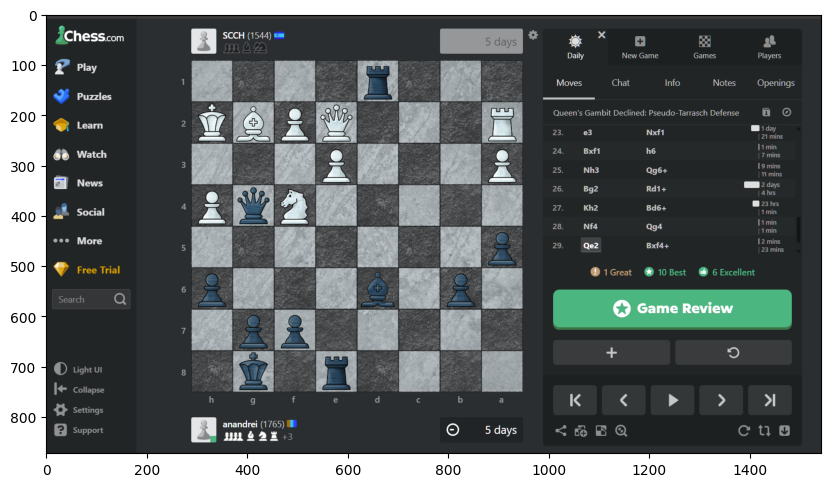

In [2]:
# Load the image
img = cv.imread(load_path)

# Set figure size globally
plt.rcParams["figure.figsize"] = (10,6)


plt.imshow(img)
plt.show()

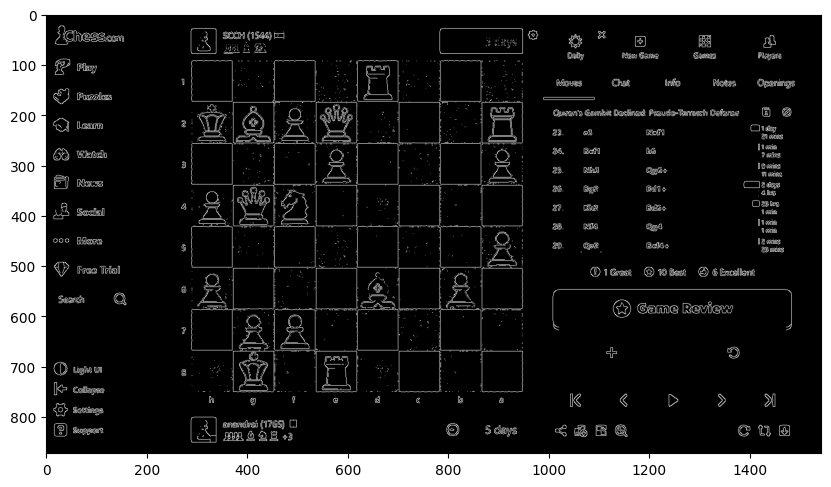

In [3]:
# Convert to grayscale and then to 8-bit
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray_8b = cv.convertScaleAbs(gray)  # converts to 8-bit

# Detect the edges of the image
edges = cv.Canny(
    image=gray_8b,
    threshold1=250,  # how many points per line before an edge gets detected
    threshold2=250,
    edges=None,
    apertureSize=3
)

# Copy edges to the images that will display the results in BGR
edges_copy = cv.cvtColor(edges, cv.COLOR_GRAY2BGR)

plt.imshow(edges_copy, cmap="gray")
plt.show()

#### TODO: when rewriting the notebook contents as a proper algorithm, I should make sure that only the board lines are identified.

#### Ideas:
- check that there are exactly 18 lines found (9 vertical, 9 horizontal): `lines.shape[0] == 18`
- horizontal lines have `theta = 0`, vertical lines have `theta = np.pi/2`
- both horizontal and vertical lines have integer `rho` (b/c it is equal to a pixel value)
- check that lines are equally spaced

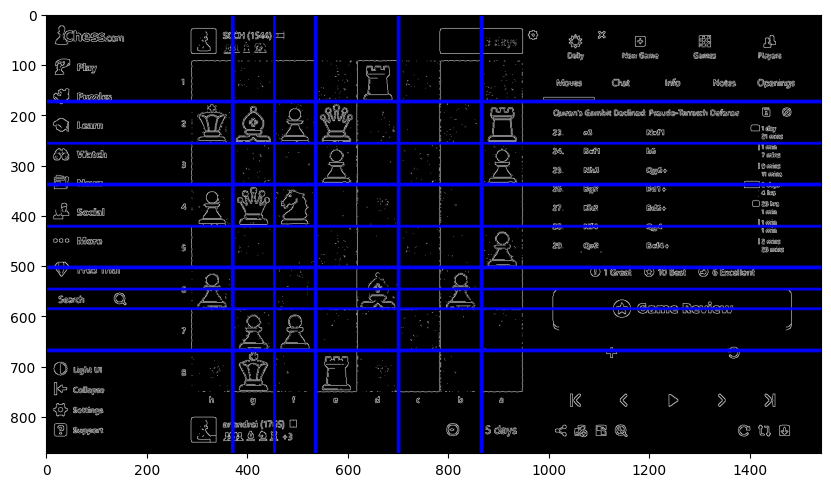

In [4]:
# Apply Hough transform to detect the lines in the image

lines = cv.HoughLines(
    image=edges,
    rho=1,  # resolution of r (polar coordinate) in pixels
    theta=np.pi / 180,  # resolution of theta (polar coordinate) in pixels
    threshold=300,  # minimum number of intersections to "*detect*" a line
    lines=None
)

# Draw the lines
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 10000*(-b)), int(y0 + 10000*(a)))
        pt2 = (int(x0 - 10000*(-b)), int(y0 - 10000*(a)))
        cv.line(edges_copy, pt1, pt2, (0, 0, 255), 3, cv.LINE_AA)

# superimpose lines on image
plt.imshow(img)
plt.imshow(edges_copy)
plt.show()

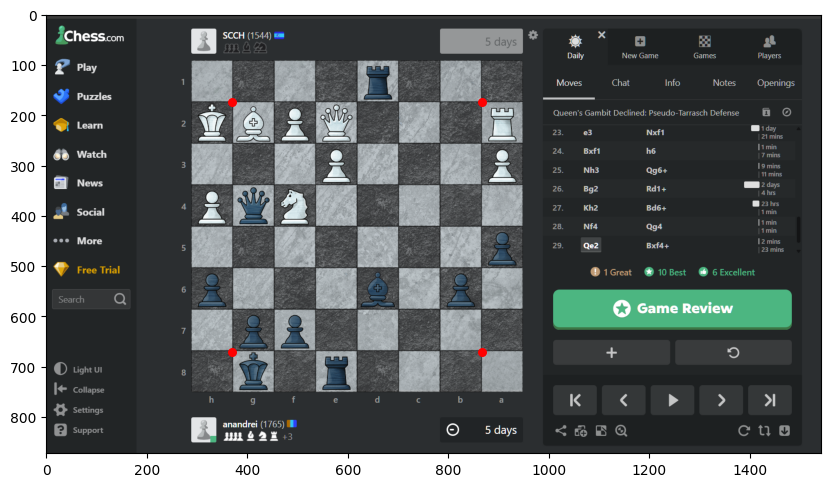

In [5]:
# Extract corners of the boards

# x coordinates of horizontal lines
horizontal = lines[np.abs(lines[:, :, 1]) < 0.1][:, 0]
horizontal = np.int16(horizontal)
horizontal = np.sort(horizontal)

# y coordinates of vertical lines
vertical = lines[np.abs(lines[:, :, 1] - np.pi/2) < 0.1][:, 0]
vertical = np.int16(vertical)
vertical = np.sort(vertical)

x_corners = [horizontal[0]]*2 + [horizontal[-1]]*2
y_corners = [vertical[0], vertical[-1]]*2

plt.imshow(img)
plt.scatter(x_corners, y_corners, c='red', s=30)
plt.show()

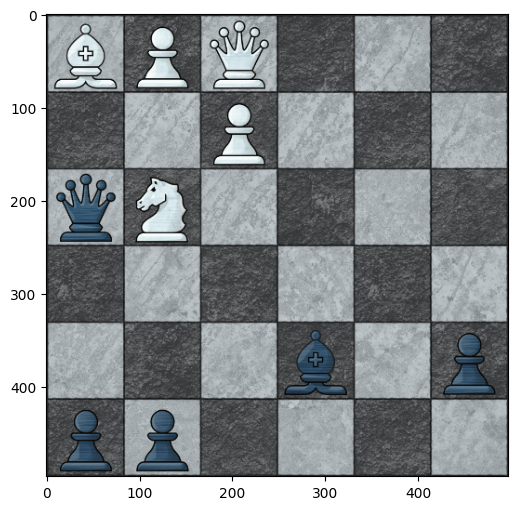

In [6]:
# Crop the image

(left, upper, right, lower) = (horizontal[0], vertical[0], horizontal[-1], vertical[-1])
with Image.fromarray(img) as img:
    cropped = img.crop(box=(left, upper, right, lower))

plt.imshow(cropped)
plt.show()